### Importing Libraries

In [353]:
import numpy as np
import dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
from matplotlib.patches import Ellipse
from skimage import io, color, measure, draw, img_as_bool
from scipy import optimize
import pandas as pd

### Importing Data from a folder which contains all DCM files

In [2]:
data_path = "/home/ctuser/myData/s1735"
output_path = working_path = "/home/ctuser/Desktop/Image_Seg/"
g = glob(data_path + "/*")

print("Total no. of CT images are: %d \nFirst 5 elements:" %len(g))
print '\n'.join(g[:5])

Total no. of CT images are: 170 
First 5 elements:
/home/ctuser/myData/s1735/i145738.CTDC.78
/home/ctuser/myData/s1735/i145815.CTDC.155
/home/ctuser/myData/s1735/i145726.CTDC.66
/home/ctuser/myData/s1735/i145724.CTDC.64
/home/ctuser/myData/s1735/i145811.CTDC.151


#### Loading CT Scan Images and calculate HU units for each pixels

In [3]:
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=1
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

#### saving output images in Hounsfield Units

In [4]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

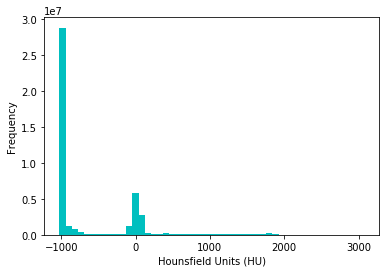

In [5]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [441]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

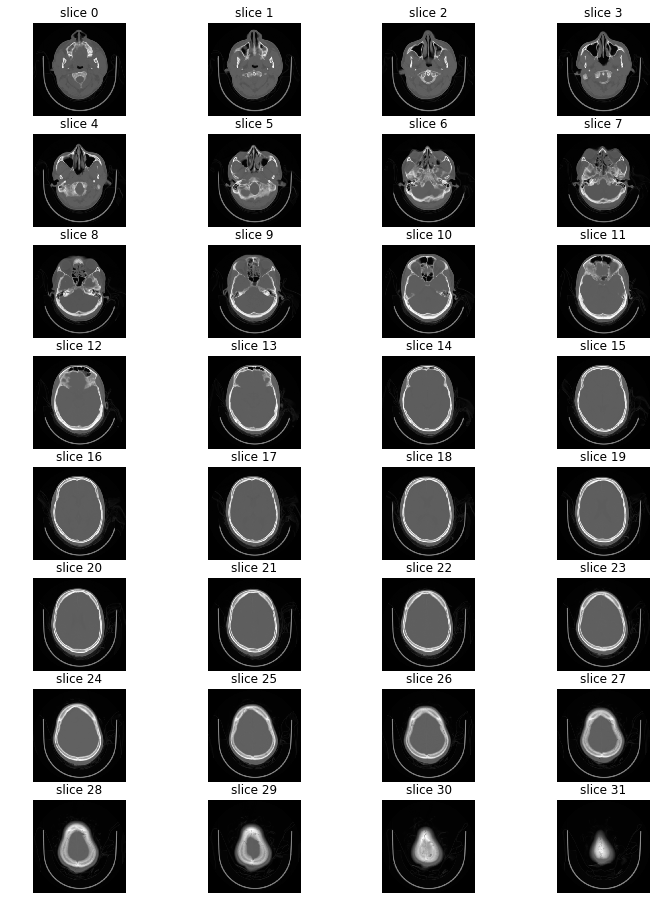

In [27]:
def sample_stack(stack, rows=8, cols=4):
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

#### A Static Elliptic filter to remove head rest

In [13]:
def filter_ellipse(imgs_array):
    for a in imgs_array:
        o,p=256,246
        arr_x,arr_y=512.0,512.0
        y,x = np.ogrid[0.0:512.0,0.0:512.0]
        mask = ((x-256.0)*(x-256.0))/(190.0*190.0) + ((y-246.0)*(y-246.0))/(215.0*215.0) > 1.0
        a[mask] = -1000
    return(imgs_array,mask)
    
ad = filter_ellipse(imgs_to_process)

#### A Linear Elliptic filter to remove head rest

In [ ]:
def filter_linear(imgs_array):
    for a in imgs_array:
        for j in range(100,450):
            for i in range(400,512):
                c=np.mean(np.array(a[j,i-20:i]))
                if c<=-999:
                    a[j,i:512]=-1000
        for j in range(100,450):
            for i in range(0,100):
                c=np.mean(np.array(a[j,i:i+20]))
                if c<=-999:
                    a[j,0:i]=-1000
            
        for i in range(0,512):
            for j in range(450,512):
                c = np.mean(np.array(a[j:j+20,i]))
                if c<=-999:
                    a[j:512,i]=-1000
                else:
                    d = np.mean(np.array(a[j-20:j,i]))
                    if d<=-999:
                        a[j:512,i]=-1000
    return(imgs_array)
imgs_to_process_1inear_filter = filter_linear(imgs_to_process)

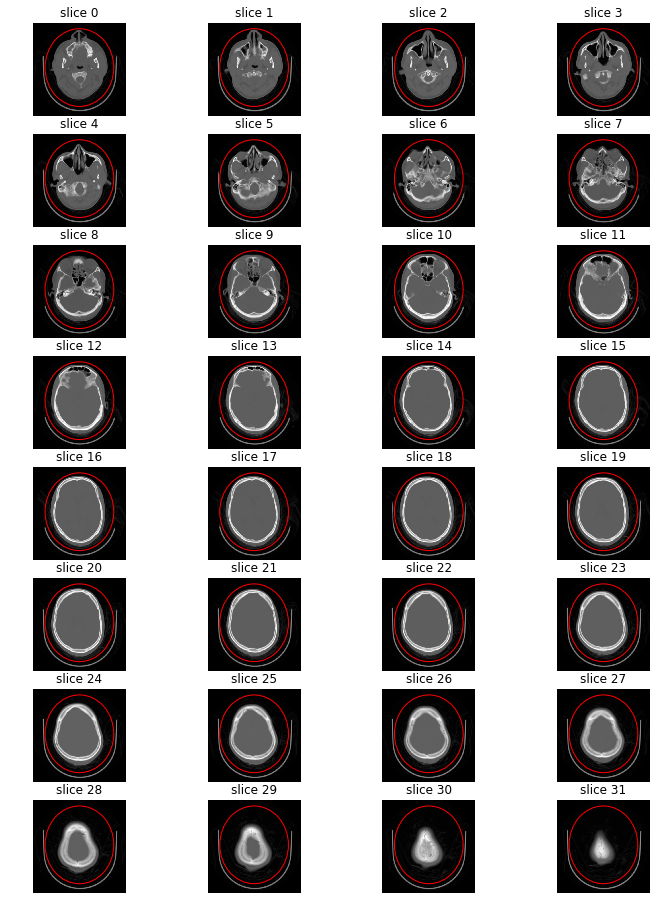

In [28]:
def sample_stack(stack, rows=8, cols=4):
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    for i in range(rows*cols):
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % i)
        ax[int(i/cols),int(i % cols)].imshow(stack[i],cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
        ellipse = Ellipse(xy=(256,246), width=380, height=430, edgecolor='r',fill=False, lw=1)
        ax[int(i/cols),int(i % cols)].add_patch(ellipse)
    plt.show()

sample_stack(imgs_to_process)

In [63]:
a = imgs_to_process[4]

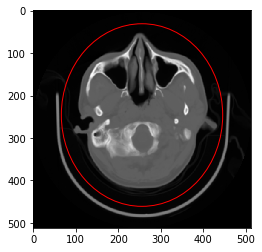

In [20]:
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
ellipse = Ellipse(xy=(256,246), width=380, height=430, edgecolor='r',fill=False, lw=1)
ax.add_patch(ellipse)
plt.show()

#### Optimal Ellipse fitting 

In [91]:
a=imgs_to_process[16]

Optimization terminated successfully.
         Current function value: -69162.000000
         Iterations: 19
         Function evaluations: 113


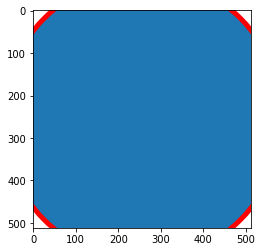

In [132]:
image = np.int16(dilated)
regions = measure.regionprops(label_image=image)
bubble = regions[0]

r, c = bubble.centroid
r_radius = bubble.major_axis_length / 2.
c_radius = bubble.minor_axis_length / 2.

def cost(params):
    r,c,r_radius,c_radius = params
    coords = draw.ellipse(r, c, r_radius,c_radius, shape=image.shape)
    template = np.zeros_like(image)
    template[coords] = 0
    return -np.sum(template == image)

r,c,r_radius,c_radius = optimize.fmin(cost, (r,c,r_radius,c_radius))

import matplotlib.pyplot as plt

f, ax = plt.subplots()
ellipse = Ellipse(xy=(r,c), width=2*c_radius, height=2*r_radius,fill=True,lw=5,edgecolor='r')
ax.imshow(image, cmap='gray', interpolation='nearest')
ax.add_artist(ellipse)
plt.show()

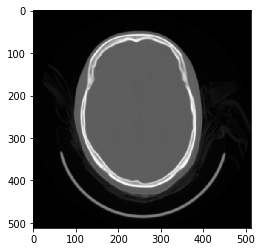

In [94]:
fig,ax = plt.subplots(1)
ax.imshow(a,cmap=plt.cm.gray)
plt.show()

Optimization terminated successfully.
         Current function value: -470.000000
         Iterations: 34
         Function evaluations: 112


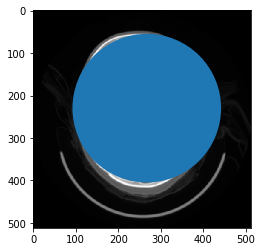

In [98]:
image = a
regions = measure.regionprops(image)
bubble = regions[0]

y0, x0 = bubble.centroid
r = bubble.major_axis_length / 2.

def cost(params):
    x0, y0, r = params
    coords = draw.circle(y0, x0, r, shape=image.shape)
    template = np.zeros_like(image)
    template[coords] = 1
    return -np.sum(template == image)

x0, y0, r = optimize.fmin(cost, (x0, y0, r))

import matplotlib.pyplot as plt

f, ax = plt.subplots()
circle = plt.Circle((x0, y0), r)
ax.imshow(image, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
plt.show()

In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))
    print(spacing)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print "Shape before resampling\t", imgs_to_process.shape
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print "Shape after resampling\t", imgs_after_resamp.shape

In [ ]:
def make_mesh(image, threshold=-300, step_size=1):

    print "Transposing surface"
    p = image.transpose(2,1,0)
    
    print "Calculating surface"
    verts, faces, norm, val = measure.marching_cubes(image, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print "Drawing"
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    f = FF()
    fig = f.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print "Drawing"
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    plt.show()


In [ ]:
v, f = make_mesh(imgs_after_resamp,700)
plt_3d(v, f)

In [ ]:
v, f = make_mesh(imgs_after_resamp, 350, 2)
plotly_3d(v, f)

In [126]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    #max = np.max(img)
    #min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

#    labels = measure.label(dilation) # Different labels are displayed in different colors
#    label_vals = np.unique(labels)
#    regions = measure.regionprops(labels)
#    good_labels = []
#    for prop in regions:
#        B = prop.bbox
#        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
#            good_labels.append(prop.label)
#    mask = np.ndarray([row_size,col_size],dtype=np.int8)
#    mask[:] = 0
#
#    #
#    #  After just the lungs are left, we do another large dilation
#    #  in order to fill in and out the lung mask 
#    #
#    for N in good_labels:
#        mask = mask + np.where(labels==N,1,0)
#    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
#
#    if (display):
#        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
#        ax[0, 0].set_title("Original")
#        ax[0, 0].imshow(img, cmap='gray')
#        ax[0, 0].axis('off')
#        ax[0, 1].set_title("Threshold")
#        ax[0, 1].imshow(thresh_img, cmap='gray')
#        ax[0, 1].axis('off')
#        ax[1, 0].set_title("After Erosion and Dilation")
#        ax[1, 0].imshow(dilation, cmap='gray')
#        ax[1, 0].axis('off')
#        ax[1, 1].set_title("Color Labels")
#        ax[1, 1].imshow(labels)
#        ax[1, 1].axis('off')
#        ax[2, 0].set_title("Final Mask")
#        ax[2, 0].imshow(mask, cmap='gray')
#        ax[2, 0].axis('off')
#        ax[2, 1].set_title("Apply Mask on Original")
#        ax[2, 1].imshow(mask*img, cmap='gray')
#        ax[2, 1].axis('off')
        
#        plt.show()
    return dilation

[0 1 2]
/n -------------------------------------------
262144
262144


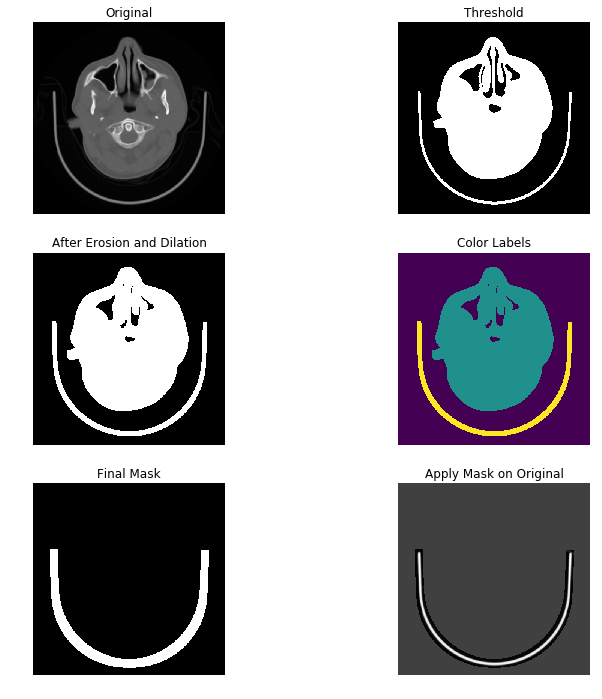

In [197]:
img = imgs_to_process[2]
dilated = make_lungmask(img, display=True)

In [439]:
#Standardize the pixel values
def min_distance(lst):
    lst = sorted(lst)
    index=-1
    dst = max(lst)-min(lst)
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] < distance:
            distance = lst[i+1] - lst[i] 
            index = i
    for i in range(len(lst)-1):
        if lst[i+1] - lst[i] == distance:
            id_1 = lst[i]
            id_2 = lst[i+1]
            print lst[i],lst[i+1]
    
def make_lungmask(img, display=False):
    img_2 = img
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    #img[img==max]=mean
    #img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(img,[np.prod(img.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,0,1)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    #eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    #dilation = morphology.dilation(thresh_img,np.ones([1,1]))

    labels = measure.label(thresh_img,neighbors=8,connectivity=2) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    print(label_vals)
    print('\n -------------------------------------------')
    labels_flat = labels.reshape(np.prod(labels.shape),1)
    labels_flat = pd.DataFrame(labels_flat)
    labels_flat.columns=['label']
    #print(labels_flat)
    #print(labels_flat.dtype)
    img_2_flat = np.array(np.reshape(img_2,[np.prod(img_2.shape),1]))
    img_2_flat = pd.DataFrame(img_2_flat)
    img_2_flat.columns = ['HU_Value']
    #print(img_2_flat)
    df=pd.DataFrame.join(labels_flat,img_2_flat)
    #print(df.head())
    std = pd.DataFrame(df.groupby('label').std())
    print (std)
    print (df.groupby('label').mean())
    
    
    
    
    
    
    
    
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 1
    mask[labels==0]= 0
    #print(good_labels)
    
    for N in labels:
        mask = mask + np.where(labels==N,1,0)
    #print(np.unique(mask))
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(thresh_img, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
       
        plt.show()
    return dilation

[0 1 2]

 -------------------------------------------
         HU_Value
label            
0       91.293487
1      208.749025
2      539.629186
         HU_Value
label            
0     -975.953209
1      202.969901
2      465.993661


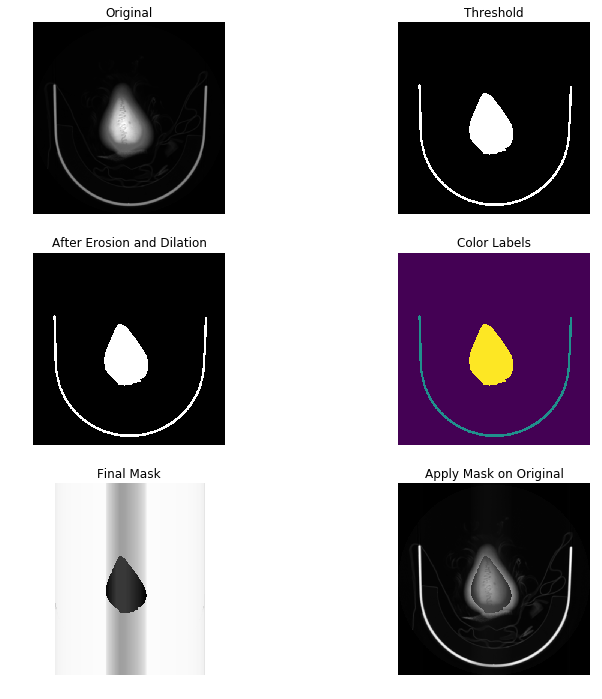

NameError: global name 'dilation' is not defined

In [446]:
img = imgs_to_process[31]
#for img in imgs_to_process:
dilated = make_lungmask(img, display=True)